<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Heshani/Research_IT22570758(Hybridmodel_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================
# Mount Google Drive
# ========================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ========================
# Imports
# ========================
import os, glob, pickle, random
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [ ]:
# ========================
# Config
# ========================
IMG_SIZE = 128
BATCH_SIZE = 16
MAX_RBC_PER_IMAGE = 25
EPOCHS = 20

In [ ]:
# ========================
# Handcrafted Features
# ========================
def target_cell_score(gray):
    h, w = gray.shape
    cx, cy = w//2, h//2
    Y, X = np.ogrid[:h, :w]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)
    r = np.max(d)
    c = gray[d < r*0.25]
    m = gray[(d >= r*0.25) & (d < r*0.5)]
    o = gray[(d >= r*0.5) & (d < r*0.75)]
    if len(c)==0 or len(m)==0 or len(o)==0:
        return 0
    return (np.mean(m)-np.mean(c)) + (np.mean(m)-np.mean(o))

def blue_ratio(rbc):
    b, g, r = cv2.split(rbc)
    return np.mean(b)/(np.mean(r)+1e-5)

def compute_rbc_features(rbc):
    gray = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    return [
        target_cell_score(gray),
        blue_ratio(rbc),
        abs(h-w)/max(h,w),
        h*w
    ]

def label_rbc(rbc):
    t, b, v, a = compute_rbc_features(rbc)
    h, w = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY).shape
    if h < 10 or w < 10:
        return "healthy"
    if t > 12 or b > 1.1 or v > 0.4 or a < 300:
        return "thalassemia"
    return "healthy"

In [ ]:
# ========================
# Extract RBCs from affected images
# ========================
def extract_rbcs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cells, labels, feats = [], [], []
    for c in contours[:MAX_RBC_PER_IMAGE]:
        if cv2.contourArea(c) < 100:
            continue
        x,y,w,h = cv2.boundingRect(c)
        rbc = image[y:y+h, x:x+w]
        cells.append(cv2.resize(rbc, (IMG_SIZE, IMG_SIZE)))
        labels.append(label_rbc(rbc))
        feats.append(compute_rbc_features(rbc))
    return cells, labels, feats

In [ ]:
# ========================
# Load datasets
# ========================
healthy_path = '/content/drive/MyDrive/thalassemia/healthy_rbc'  # individual RBCs
affected_path = '/content/drive/MyDrive/thalassemia/affected'    # full images

X_healthy, y_healthy, f_healthy = [], [], []

# Healthy/anemia RBCs (already extracted)
for p in glob.glob(os.path.join(healthy_path, '*')):
    rbc = cv2.imread(p)
    if rbc is not None:
        X_healthy.append(cv2.resize(rbc, (IMG_SIZE, IMG_SIZE)))
        y_healthy.append("healthy")
        f_healthy.append(compute_rbc_features(rbc))

# Affected images (extract RBCs)
X_thal, y_thal, f_thal = [], [], []
for p in glob.glob(os.path.join(affected_path, '*')):
    img = cv2.imread(p)
    if img is not None:
        c,l,f = extract_rbcs(img)
        X_thal.extend(c)
        y_thal.extend(l)
        f_thal.extend(f)

# Combine
X_all = np.array(X_healthy + X_thal)
y_all = np.array(y_healthy + y_thal)
f_all = np.array(f_healthy + f_thal)

# ========================
# Encode & scale
# ========================
le = LabelEncoder()
y_all_encoded = le.fit_transform(y_all)

scaler = StandardScaler()
f_all_scaled = scaler.fit_transform(f_all)

# ========================
# Manual Train/Validation/Test Split
# ========================
# Shuffle indices
indices = np.arange(len(X_all))
np.random.seed(42)
np.random.shuffle(indices)

# Split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

n_total = len(indices)
n_train = int(train_split * n_total)
n_val = int(val_split * n_total)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

X_train, X_val, X_test = X_all[train_idx], X_all[val_idx], X_all[test_idx]
y_train, y_val, y_test = y_all_encoded[train_idx], y_all_encoded[val_idx], y_all_encoded[test_idx]
f_train, f_val, f_test = f_all_scaled[train_idx], f_all_scaled[val_idx], f_all_scaled[test_idx]

# ========================
# Class weights
# ========================
class_weights = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))

# ========================
# Data Augmentation
# ========================
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomTranslation(0.1,0.1)
])

In [ ]:
# ========================
# CNN + ViT MODEL
# ========================
def build_model(num_classes):
    img_in = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    feat_in = layers.Input((4,))
    x = augment(img_in)

    # CNN branch
    base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    for layer in base.layers[:-10]:
        layer.trainable = False
    cnn = layers.GlobalAveragePooling2D()(base.output)
    cnn = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(cnn)
    cnn = layers.Dropout(0.3)(cnn)

    # ViT branch
    p = layers.Conv2D(64, 16, strides=16)(x)
    p = layers.Reshape((-1, 64))(p)
    for _ in range(3):
        a = layers.MultiHeadAttention(num_heads=4, key_dim=64)(p, p)
        p = layers.LayerNormalization()(p + a)
        f = layers.Dense(64, activation='relu')(p)
        p = layers.LayerNormalization()(p + f)
    vit = layers.GlobalAveragePooling1D()(p)

    # Fusion
    m = layers.Concatenate()([cnn, vit, feat_in])
    m = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(m)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.4)(m)
    out = layers.Dense(num_classes, activation='softmax')(m)

    model = models.Model([img_in, feat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model

model = build_model(len(np.unique(y_train)))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ sequential[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 24,016,002 (91.61 MB)

 Trainable params: 4,893,442 (18.67 MB)

 Non-trainable params: 19,122,560 (72.95 MB)

In [ ]:
# ========================
# Train
# ========================
history = model.fit(
    [X_train, f_train], tf.keras.utils.to_categorical(y_train),
    validation_data=([X_val, f_val], tf.keras.utils.to_categorical(y_val)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6197 - loss: 0.9385 - val_accuracy: 0.8707 - val_loss: 0.5015
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7013 - loss: 0.7654 - val_accuracy: 0.8276 - val_loss: 0.4986
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7341 - loss: 0.6679 - val_accuracy: 0.8233 - val_loss: 0.5004
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7057 - loss: 0.7294 - val_accuracy: 0.8491 - val_loss: 0.5023
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7614 - loss: 0.6537 - val_accuracy: 0.6897 - val_loss: 0.7963
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7655 - loss: 0.6225 - val_accuracy: 0.7414 - val_loss: 0.6646
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7488 - loss: 0.6526 - val_accuracy: 0.8966 - val_loss: 0.4451
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7484 - loss: 0.6429 - val_accuracy: 0.7888 - v

In [ ]:
# ========================
# Evaluate
# ========================
pred = np.argmax(model.predict([X_test, f_test]), axis=1)
print("TEST ACCURACY:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=le.classes_))

# ========================

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
TEST ACCURACY: 0.8798283261802575
              precision    recall  f1-score   support

     healthy       0.87      0.83      0.85        95
 thalassemia       0.89      0.91      0.90       138

    accuracy                           0.88       233
   macro avg       0.88      0.87      0.87       233
weighted avg       0.88      0.88      0.88       233



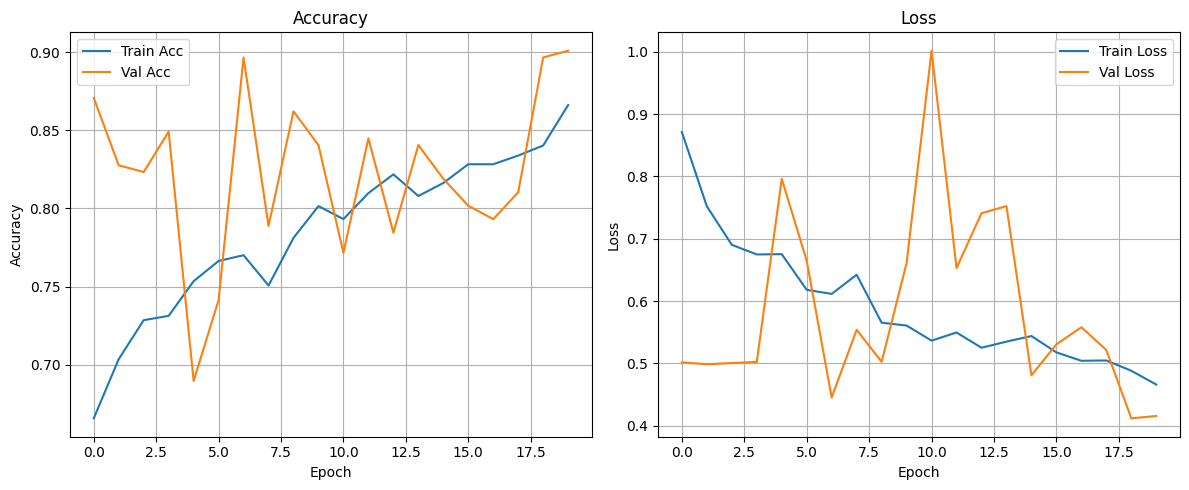

In [ ]:
# ========================
# Plot Accuracy & Loss
# ========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ========================
# Save model & encoders
# ========================
model.save("cnn_vit_rbc_manualsplit.keras")
pickle.dump(le, open("label_encoder.pkl","wb"))
pickle.dump(scaler, open("scaler.pkl","wb"))

print("\n✅ Final model saved with manual RBC extraction and proper split")



✅ Final model saved with manual RBC extraction and proper split
